## Accessing Landsat TM/MSS data on Azure

The [Landsat](https://landsat.gsfc.nasa.gov/) program has been imaging the Earth since 1972; it provides a comprehensive, continuous archive of the Earth's surface.  This dataset represents the global archive of data from the [thematic mapper](https://landsat.gsfc.nasa.gov/landsat-4-5/tm) (TM) and [multispectral spanner system](https://landsat.gsfc.nasa.gov/multispectral-scanner-system) (MSS) instruments that were carried aboard the [Landsat 1](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-1), [Landsat 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-2), [Landsat 3](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-3), [Landsat 4](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-4) and [Landsat 5](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-5) satellites.  MSS data represent the period from 1972-2013 (Landsat 1-5), at 80m resolution.  TM data represent the period from 1982-2012 (Landsat 4-5), at 30m resolution.

This notebook demonstrates basic access to Landsat TM/MSS data on Azure, using the NASA CMR API to query for tiles, then accessing the tiles on Azure blob storage.  Because this collection is in preview, the user needs to provide storage credentials. The user also needs to provide credentials for the NASA CMR API.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-landsat-tm-mss](http://aka.ms/ai4edata-landsat-tm-mss).

### Imports

In [12]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import rasterio.features
from rasterio.windows import Window
from pyproj import Transformer        

from azure.storage.blob import ContainerClient
from cmr import GranuleQuery

from lxml import etree
import unicodedata

### Constants

In [26]:
# Let's take a look at an area near Auckland, New Zealand
query_lon = 174.92446857141755
query_lat = -36.89307045544658

sensor_short_name = 'tm'
# sensor_short_name = 'mss'

if sensor_short_name == 'tm':
    query_short_name = 'Landsat4-5_TM_C1'
    query_start_date = datetime.datetime(1982, 1, 1, 0, 0, 0)
    query_end_date = datetime.datetime(2012, 12, 1, 0, 0, 0)
    rgb_bands = ['B3','B2','B1']
else:
    assert sensor_short_name == 'mss'
    query_short_name = 'Landsat1-5_MSS_C1'
    query_start_date = datetime.datetime(1972, 1, 1, 0, 0, 0)
    query_end_date = datetime.datetime(2013, 12, 1, 0, 0, 0)
    rgb_bands = ['B5','B4','B6']

# This should be a text file with a SAS token for the Landsat container on the first line
sas_file = os.path.expanduser('~/tokens/landsat_sas.txt')

# Maps instrument names as they appear in CMR results to the short names used in filenames
instrument_mapping = {
    'Landsat 4-5 Thematic Mapper Collection 1 V1':'tm',
    'Landsat 1-5 Multispectral Scanner (MSS) Collection 1 V1':'mss'}

# Normalization value for rendering
composite_norm_value = 25000
        
# Select a thumbnail for thumbnail rendering (six are available for Landsat C2 files)
thumbnail_index = -3
        
# When rendering whole images, how much should we downscale?
dsfactor = 10

# We're going to render a nice image at the end, set the size and "zoom"
target_size = [800,400]
oversample = 3.0

### Azure storage constants

In [27]:
lines = []
with open(sas_file,'r') as f:
    lines = f.readlines()
assert len(lines) >= 1
sas_token = lines[0].strip()
        
storage_account_name = 'landsateuwest'
container_name = 'landsat-c2'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                                 container_name=container_name,
                                                 credential=sas_token)

### Search for granules

Later we're going to work with json-formatted results, and this is also a fast way to get the total number of results, so we'll fetch these, then set them aside for a bit while we make a second query to get cloud cover information, which is only available in the xml results.

In [28]:
api = GranuleQuery()
json_granules = api.short_name(query_short_name).point(query_lon,query_lat).temporal(query_start_date, query_end_date).get()

print('Found {} granules'.format(len(json_granules)))

Found 202 granules


### Retrieve xml-formatted metadata 

In [29]:
# Retrieve results in echo10 format, which is less convenient than the default .json, but
# includes cloud cover information, which the .json results don't (for Landsat)
api = GranuleQuery()
api.parameters(
    short_name=query_short_name,
    point=(query_lon, query_lat),
    temporal=(query_start_date,query_end_date)
)
xml_results = api.format('echo10').get(len(json_granules))

In [30]:
xml = xml_results[0]
xml = unicodedata.normalize('NFKD', xml).encode('ascii', 'ignore')
tree = etree.fromstring(xml)
xml_granules = tree.findall("result/Granule")

lowest_cloud_cover = None
granule_name = None

for granule in xml_granules:
    attributes = granule.find('AdditionalAttributes')
    for a in attributes:
        name = a.find('Name').text
        if name == 'LandCloudCover' or name == 'LandCloudCoverPct':
            cc = float(a.find('Values').find('Value').text)
            if lowest_cloud_cover is None or cc < lowest_cloud_cover:
                lowest_cloud_cover = cc
                granule_name = granule.find('GranuleUR').text
            break

### Select the granule with the lowest cloud cover

In [31]:
# Find the json-formatted granule with the same name
granule = [g for g in json_granules if g['title'] == granule_name]
assert len(granule) == 1
granule = granule[0]

# E.g. 'LE07_L1TP_074086_20200328_20200424_01_T1'
granule_id = granule['title']
print('Accessing tile {}'.format(granule_id))

Accessing tile LT04_L1TP_073086_19890604_20170203_01_T1


### Map this to our Azure blob paths

In [32]:
if 'MSS' in query_short_name:
    level = 'level-1'
else:
    level = 'level-2'
    
category = 'standard'
sensor = instrument_mapping[granule['dataset_id']]

# E.g., 2020-01-03T19:01:46.557Z
date = granule['time_start']
year = date[0:4]
month = date[5:7]
day = date[8:10]

path = granule_id[10:13]
row = granule_id[13:16]

row_folder = '/'.join([level,category,sensor,year,path,row])

# E.g. 01152004
granule_date_string = granule_id[11:19]

granule_month = granule_date_string[0:2]
granule_day = granule_date_string[2:4]
granule_year = granule_date_string[4:8]

# E.g. LC08_L1TP_047027_20200103
scene_prefix = granule_id[0:25]

# E.g. LC08_L2SP_047027_20200103
scene_prefix = scene_prefix[0:5] + 'L2SP' + scene_prefix[9:]

azure_scene_prefix = row_folder + '/' + scene_prefix

### Enumerate image files

In [33]:
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_paths = [blob.name for blob in generator if blob.name.endswith('.TIF')]

print('Found {} images:'.format(len(image_paths)))
for fn in image_paths:
    print(fn.split('/')[-1])

Found 19 images:
LT04_L2SP_073086_19890604_20200916_02_T1_QA_PIXEL.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_QA_RADSAT.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_ATMOS_OPACITY.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B1.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B2.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B3.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B4.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B5.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_B7.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_SR_CLOUD_QA.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_ATRAN.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_B6.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_CDIST.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_DRAD.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_EMIS.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_EMSD.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_QA.TIF
LT04_L2SP_073086_19890604_20200916_02_T1_ST_TRAD.TIF
LT04_L2SP_073086_19890604_2

### Convert to Azure URLs

In [34]:
azure_urls = [storage_account_url + container_name + '/' + p + sas_token for p in image_paths]

### Choose bands for an RGB composite

In [35]:
# From https://www.usgs.gov/media/images/common-landsat-band-rgb-composites
rgb_bands = ['B3','B2','B1']
rgb_urls = []
for band_name in rgb_bands:
    rgb_urls.append([s for s in azure_urls if band_name + '.TIF' in s][0])

### Render previews without reading the whole file

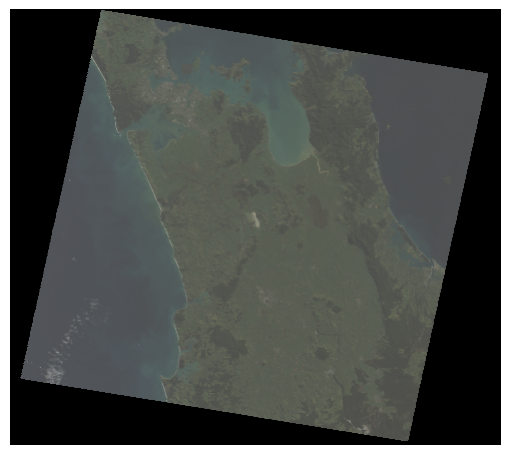

In [36]:
thumbnail_data = []

# url = rgb_urls[0]
for url in rgb_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve a small-ish thumbnail (six are available for Landsat files)
        decimation_level = oviews[thumbnail_index]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w)) / composite_norm_value
        thumbnail_data.append(thumbnail_channel)

rgb = np.dstack((thumbnail_data[0],thumbnail_data[1],thumbnail_data[2]))
np.clip(rgb,0,1,rgb)

dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);

### Render composite image

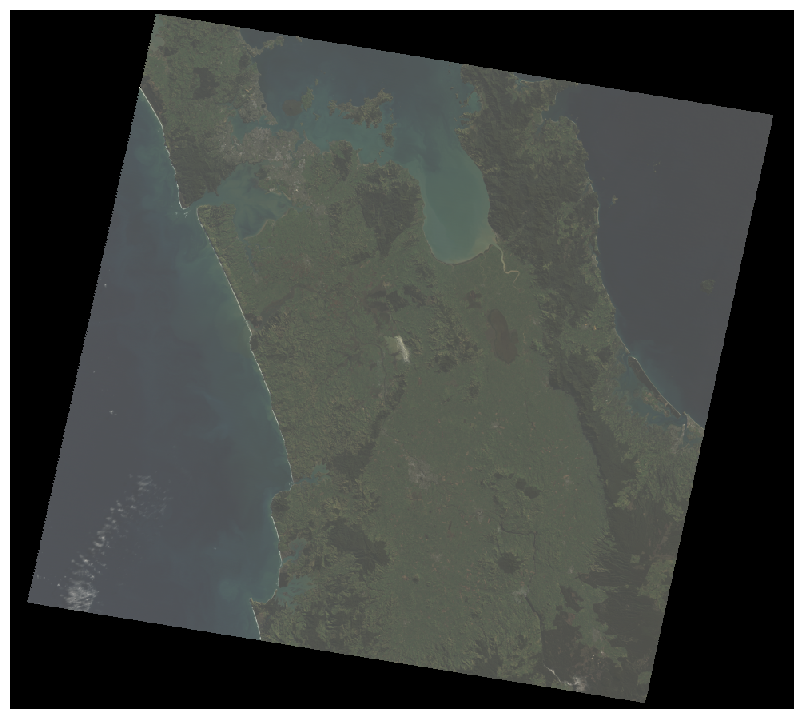

In [37]:
image_data = []

for fn in rgb_urls:
    with rasterio.open(fn,'r') as raster:
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);

### Crop a region

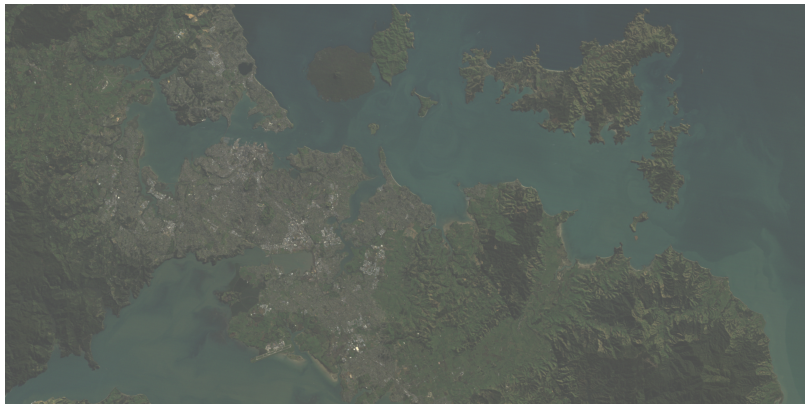

In [38]:
image_data = []

for fn in rgb_urls:
    
    with rasterio.open(fn,'r') as src:
        
        # Choose the target image size
        xsize = (target_size[0] * oversample)
        ysize = (target_size[1] * oversample)
        
        # Find the transformation from pixels to lat/lon
        transformer = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True)
        xx, yy = transformer.transform(query_lon, query_lat)
        py, px = src.index(xx,yy)
        xoff = px - xsize // 2 
        yoff = py - ysize // 2 
        window = Window(xoff,yoff,xsize,ysize)
        
        band_array = src.read(1, window=window)
        src.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

    # ...with rasterio.open()
    
# ...for each file
    
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

w = target_size[0]
h = target_size[1]

dpi = 50; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(rgb);